## Second Hand Car Price Prediction
<hr>

By: Alejandro Serrano Fernández


Import necessary libraries

In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Normalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

### Data Exploration and Processing

In [2]:
df = pd.read_csv('second_hand_dataset.csv')

In [3]:
df.head(15)

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5
5,6,650007,844846,6,148846,2,9,13,138,61,109,177933.5
6,7,633344,756063,5,78025,1,9,15,171,94,132,410877.0
7,8,662990,891569,6,76546,1,2,12,146,109,96,467471.5
8,9,543184,841354,7,57662,4,7,14,151,50,132,462397.5
9,10,573043,879481,2,132347,2,3,12,200,115,82,197266.0


In [4]:
df.describe()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.00000
mean,500.500000,601648.286000,799131.3970,4.561000,100274.430000,2.988000,5.592000,11.625000,166.89300,84.54600,103.423000,308520.24250
std,288.819436,58407.246204,57028.9502,1.719079,29150.463233,1.402791,2.824449,2.230549,19.28838,20.51694,21.058716,126073.25915
min,1.000000,500265.000000,700018.0000,2.000000,50324.000000,1.000000,1.000000,8.000000,135.00000,50.00000,68.000000,28226.50000
25%,250.750000,548860.500000,750997.7500,3.000000,74367.500000,2.000000,3.000000,10.000000,150.00000,67.00000,85.000000,206871.75000
50%,500.500000,601568.000000,798168.0000,5.000000,100139.500000,3.000000,6.000000,12.000000,166.00000,84.00000,104.000000,306717.75000
75%,750.250000,652267.250000,847563.2500,6.000000,125048.000000,4.000000,8.000000,13.000000,184.00000,102.00000,121.000000,414260.87500
max,1000.000000,699859.000000,899797.0000,7.000000,149902.000000,5.000000,10.000000,15.000000,200.00000,120.00000,140.000000,584267.50000


In [5]:
df.isnull().sum()

v.id             0
on road old      0
on road now      0
years            0
km               0
rating           0
condition        0
economy          0
top speed        0
hp               0
torque           0
current price    0
dtype: int64

In [6]:
df = df.drop(["v.id", "on road old", "on road now"], axis=1)

c:\Users\aleja\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


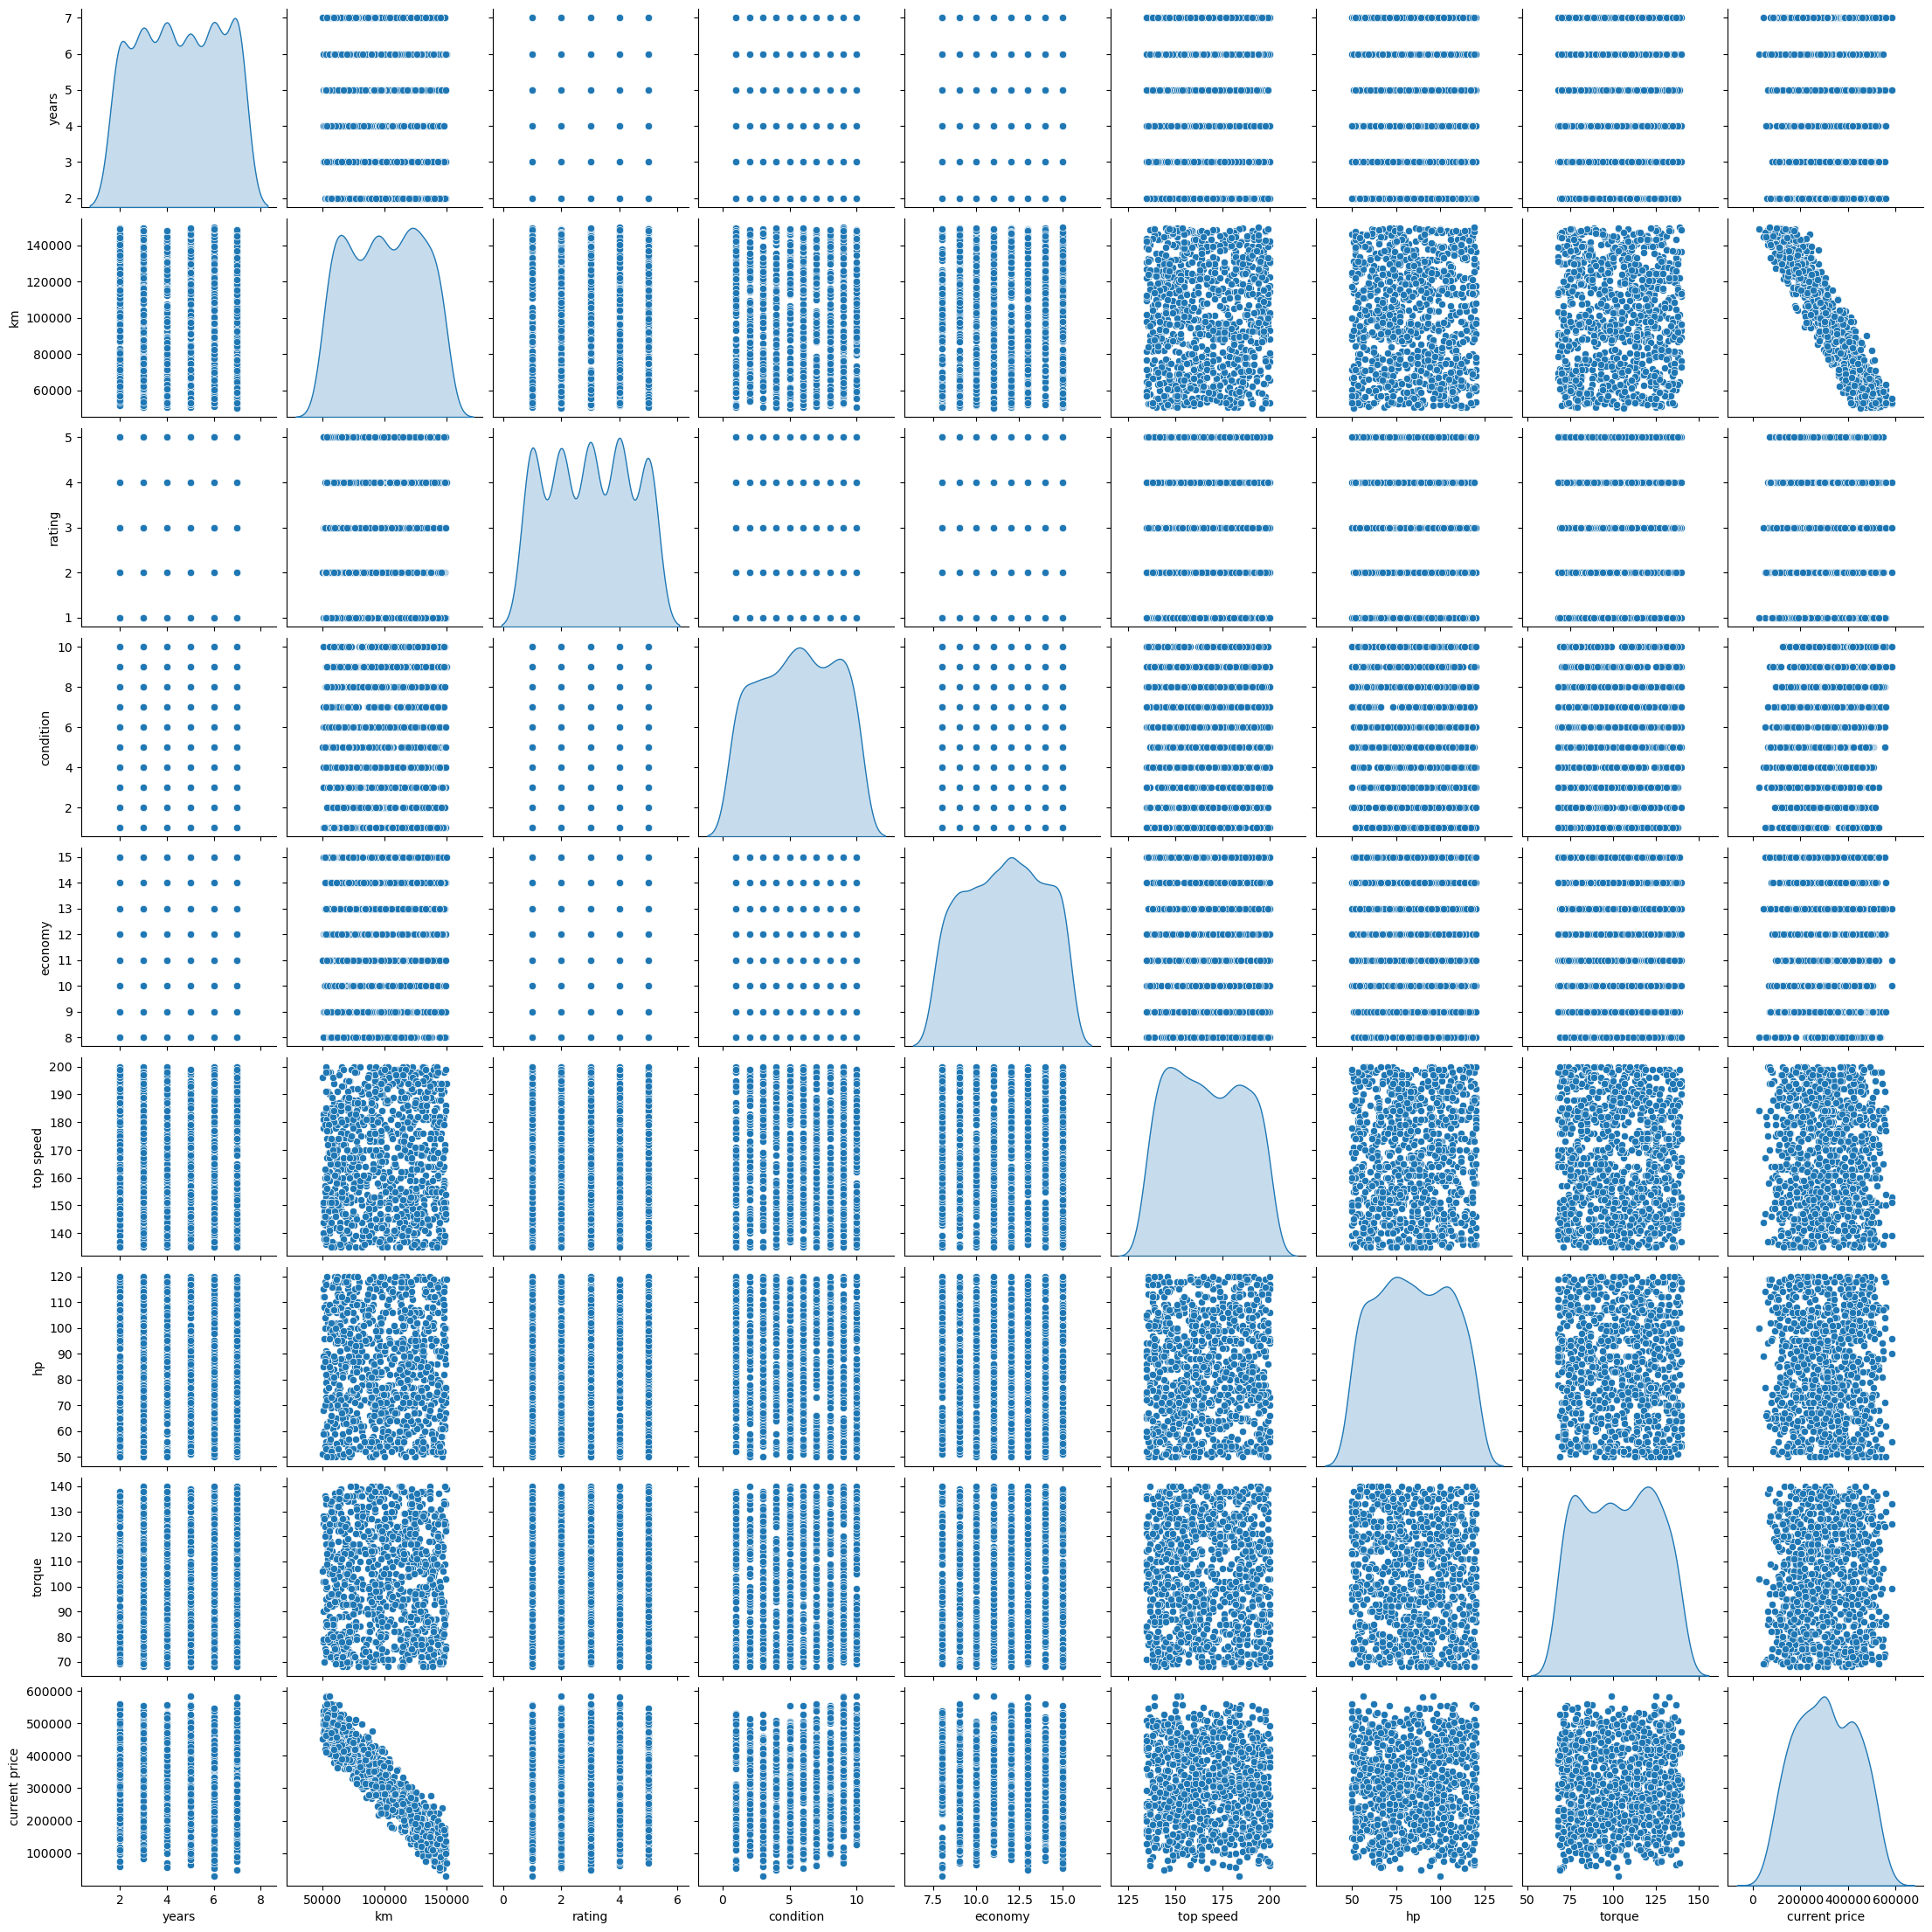

In [7]:
sns.pairplot(df, diag_kind="kde")

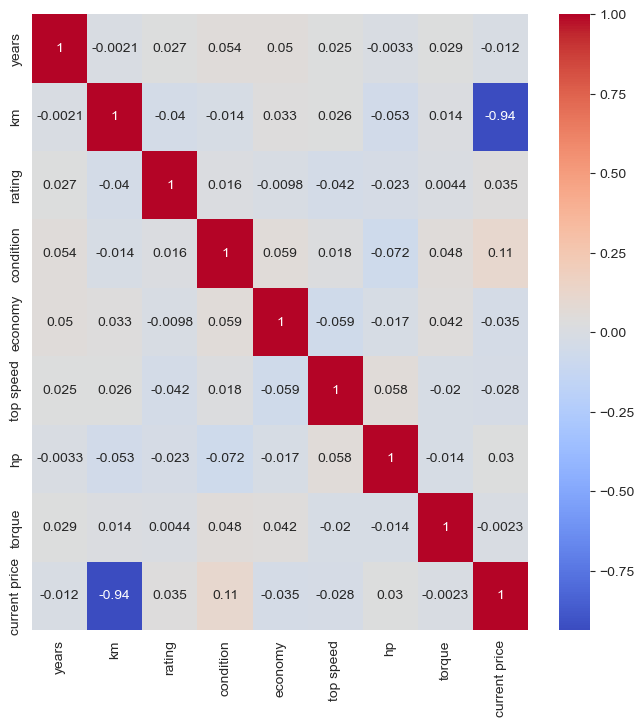

In [11]:
corr = df.corr(method='pearson')

plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

The high correlation between kilometers and price may have important implications for the used car market. It could indicate that the wear and tear associated with higher kilometres driven directly influences car valuation.

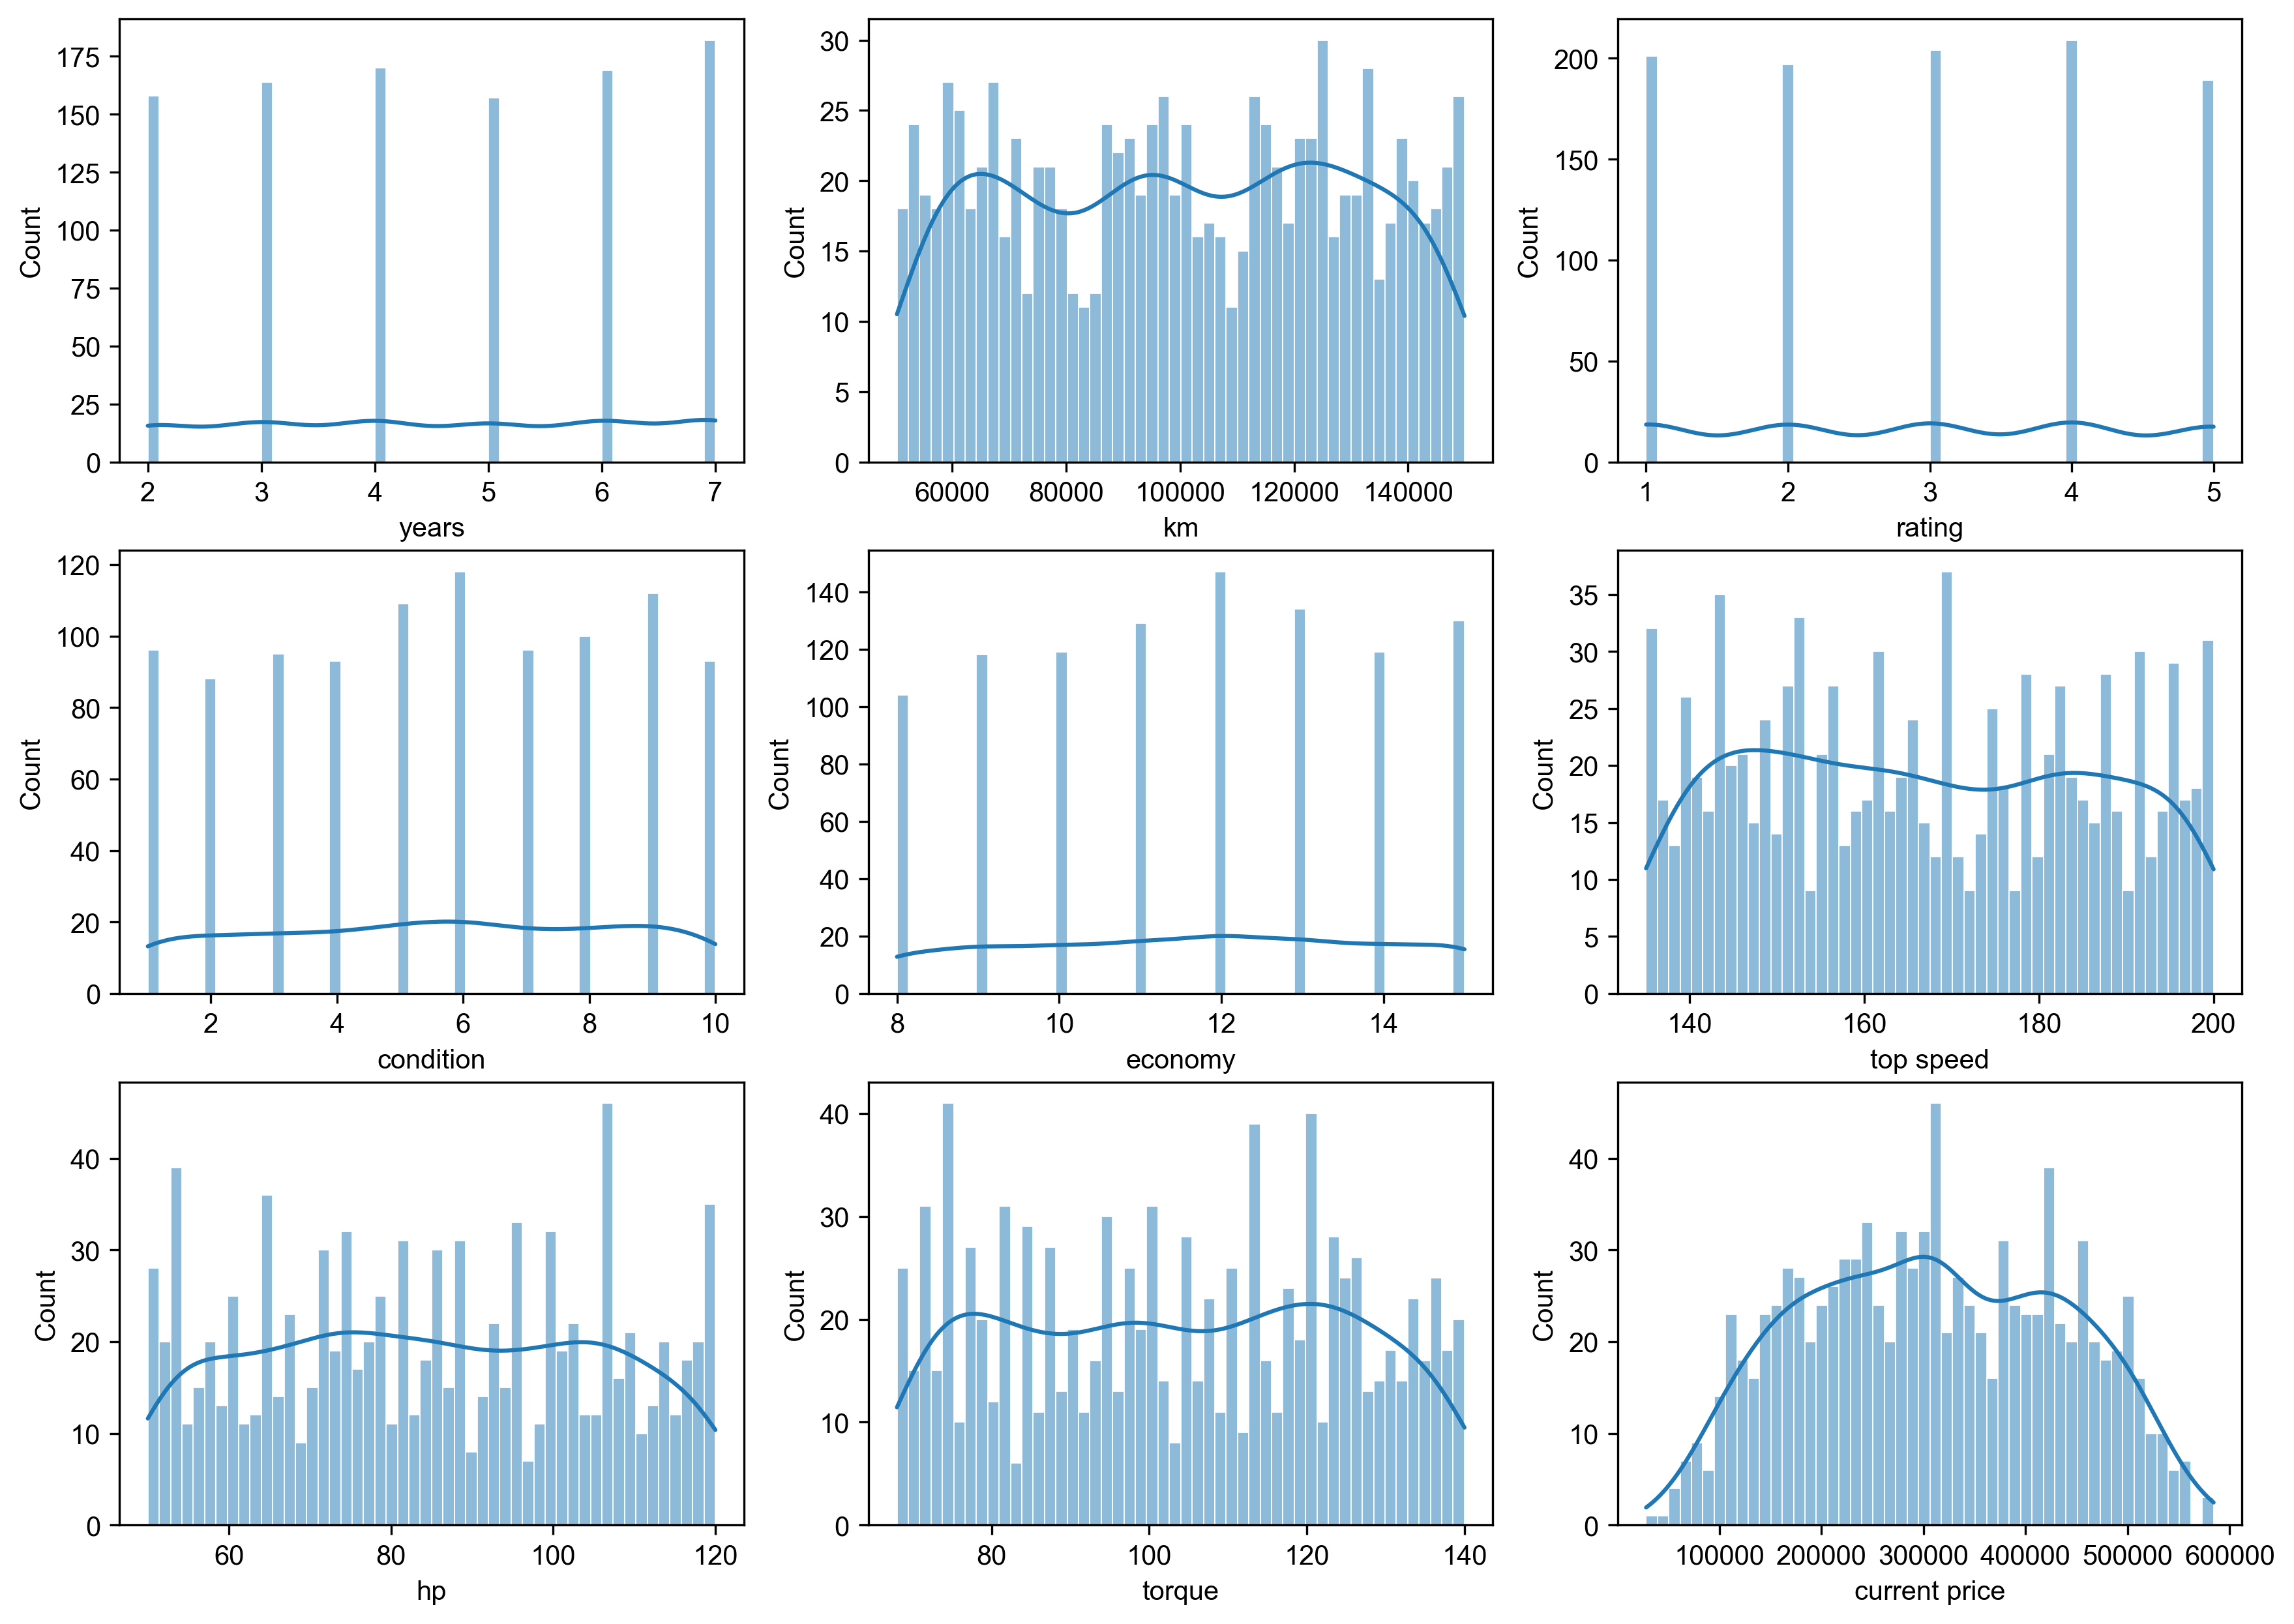

In [8]:
fig, ax = plt.subplots(figsize=(14, 10), ncols=3, nrows=3, dpi=300)
sns.set_style("darkgrid")
for i, column in enumerate(df.columns):
    sns.histplot(df[column], ax=ax[i//3][i%3], kde=True, bins=50)

plt.show()

It is noteworthy that only the pricing of vehicles appears to follow a normal distribution. 

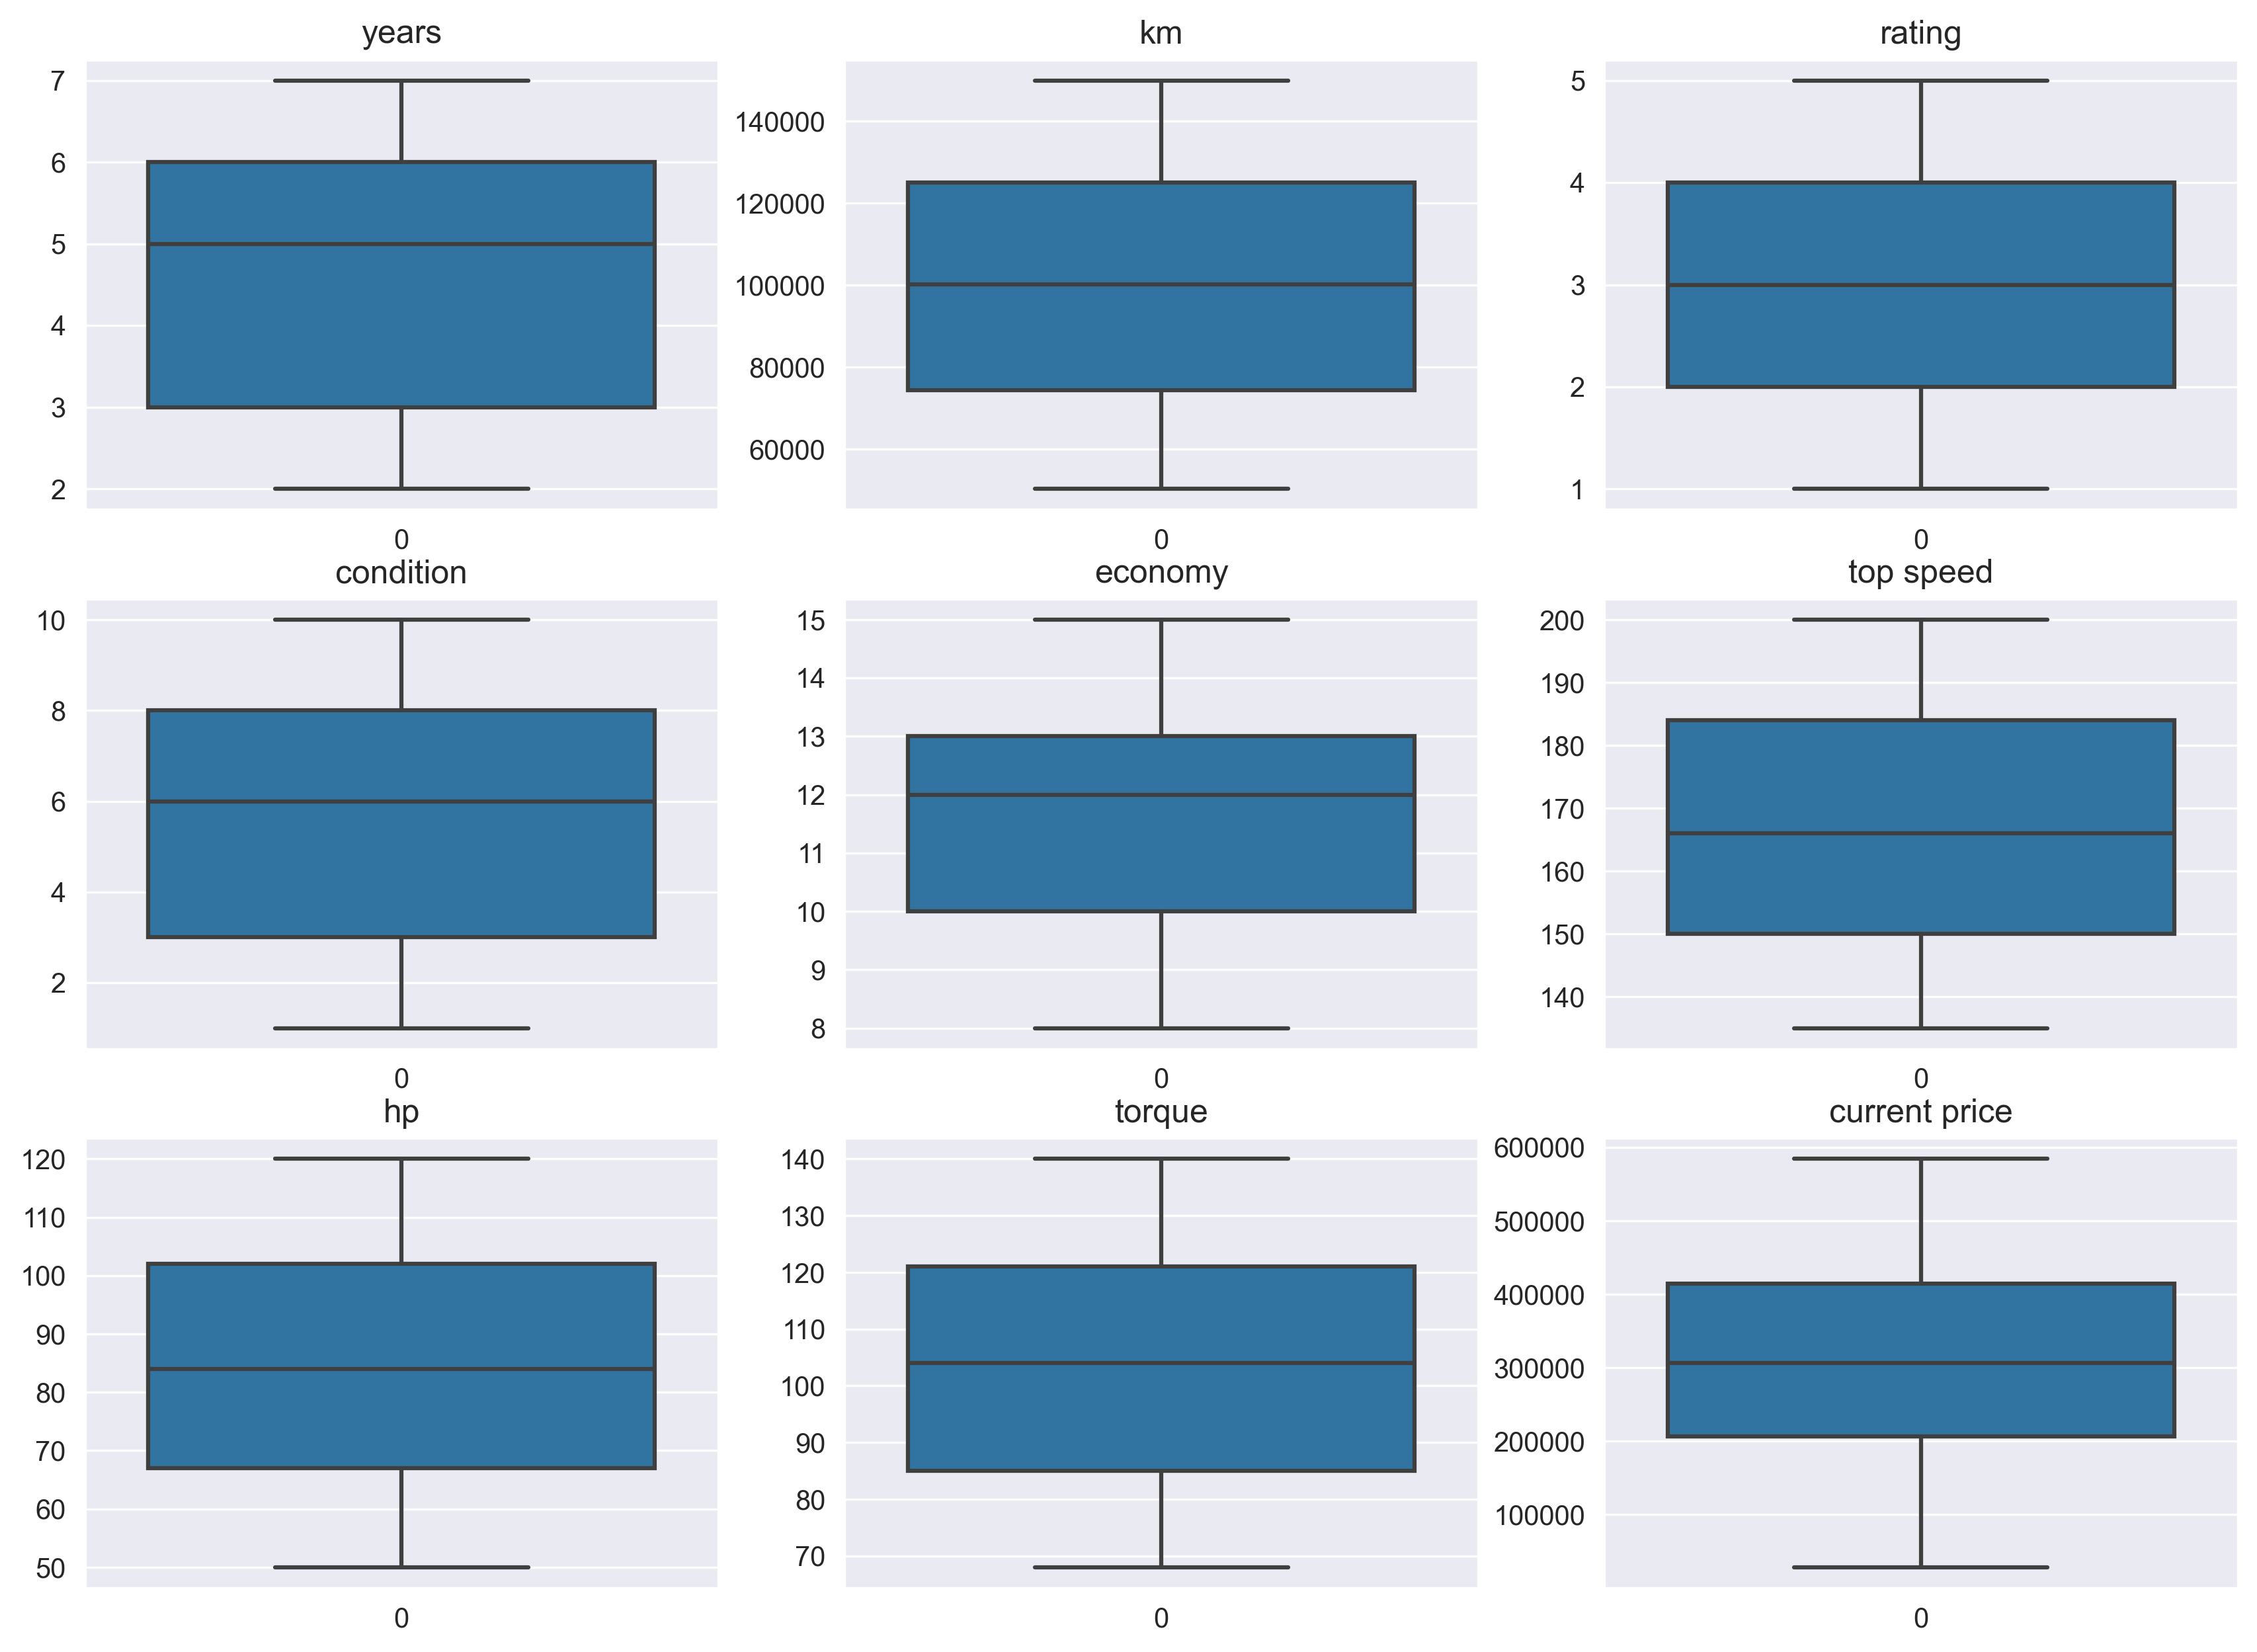

In [9]:
fig, ax = plt.subplots(figsize=(14, 10), ncols=3, nrows=3, dpi=300)
for i, column in enumerate(df.columns):
    sns.boxplot(df[column], ax=ax[i//3][i%3]).set_title(column)

plt.show()

It is noticeable that there are no outliers present. This indicates there isn´t any extreme values that significantly deviate from the overall pattern.

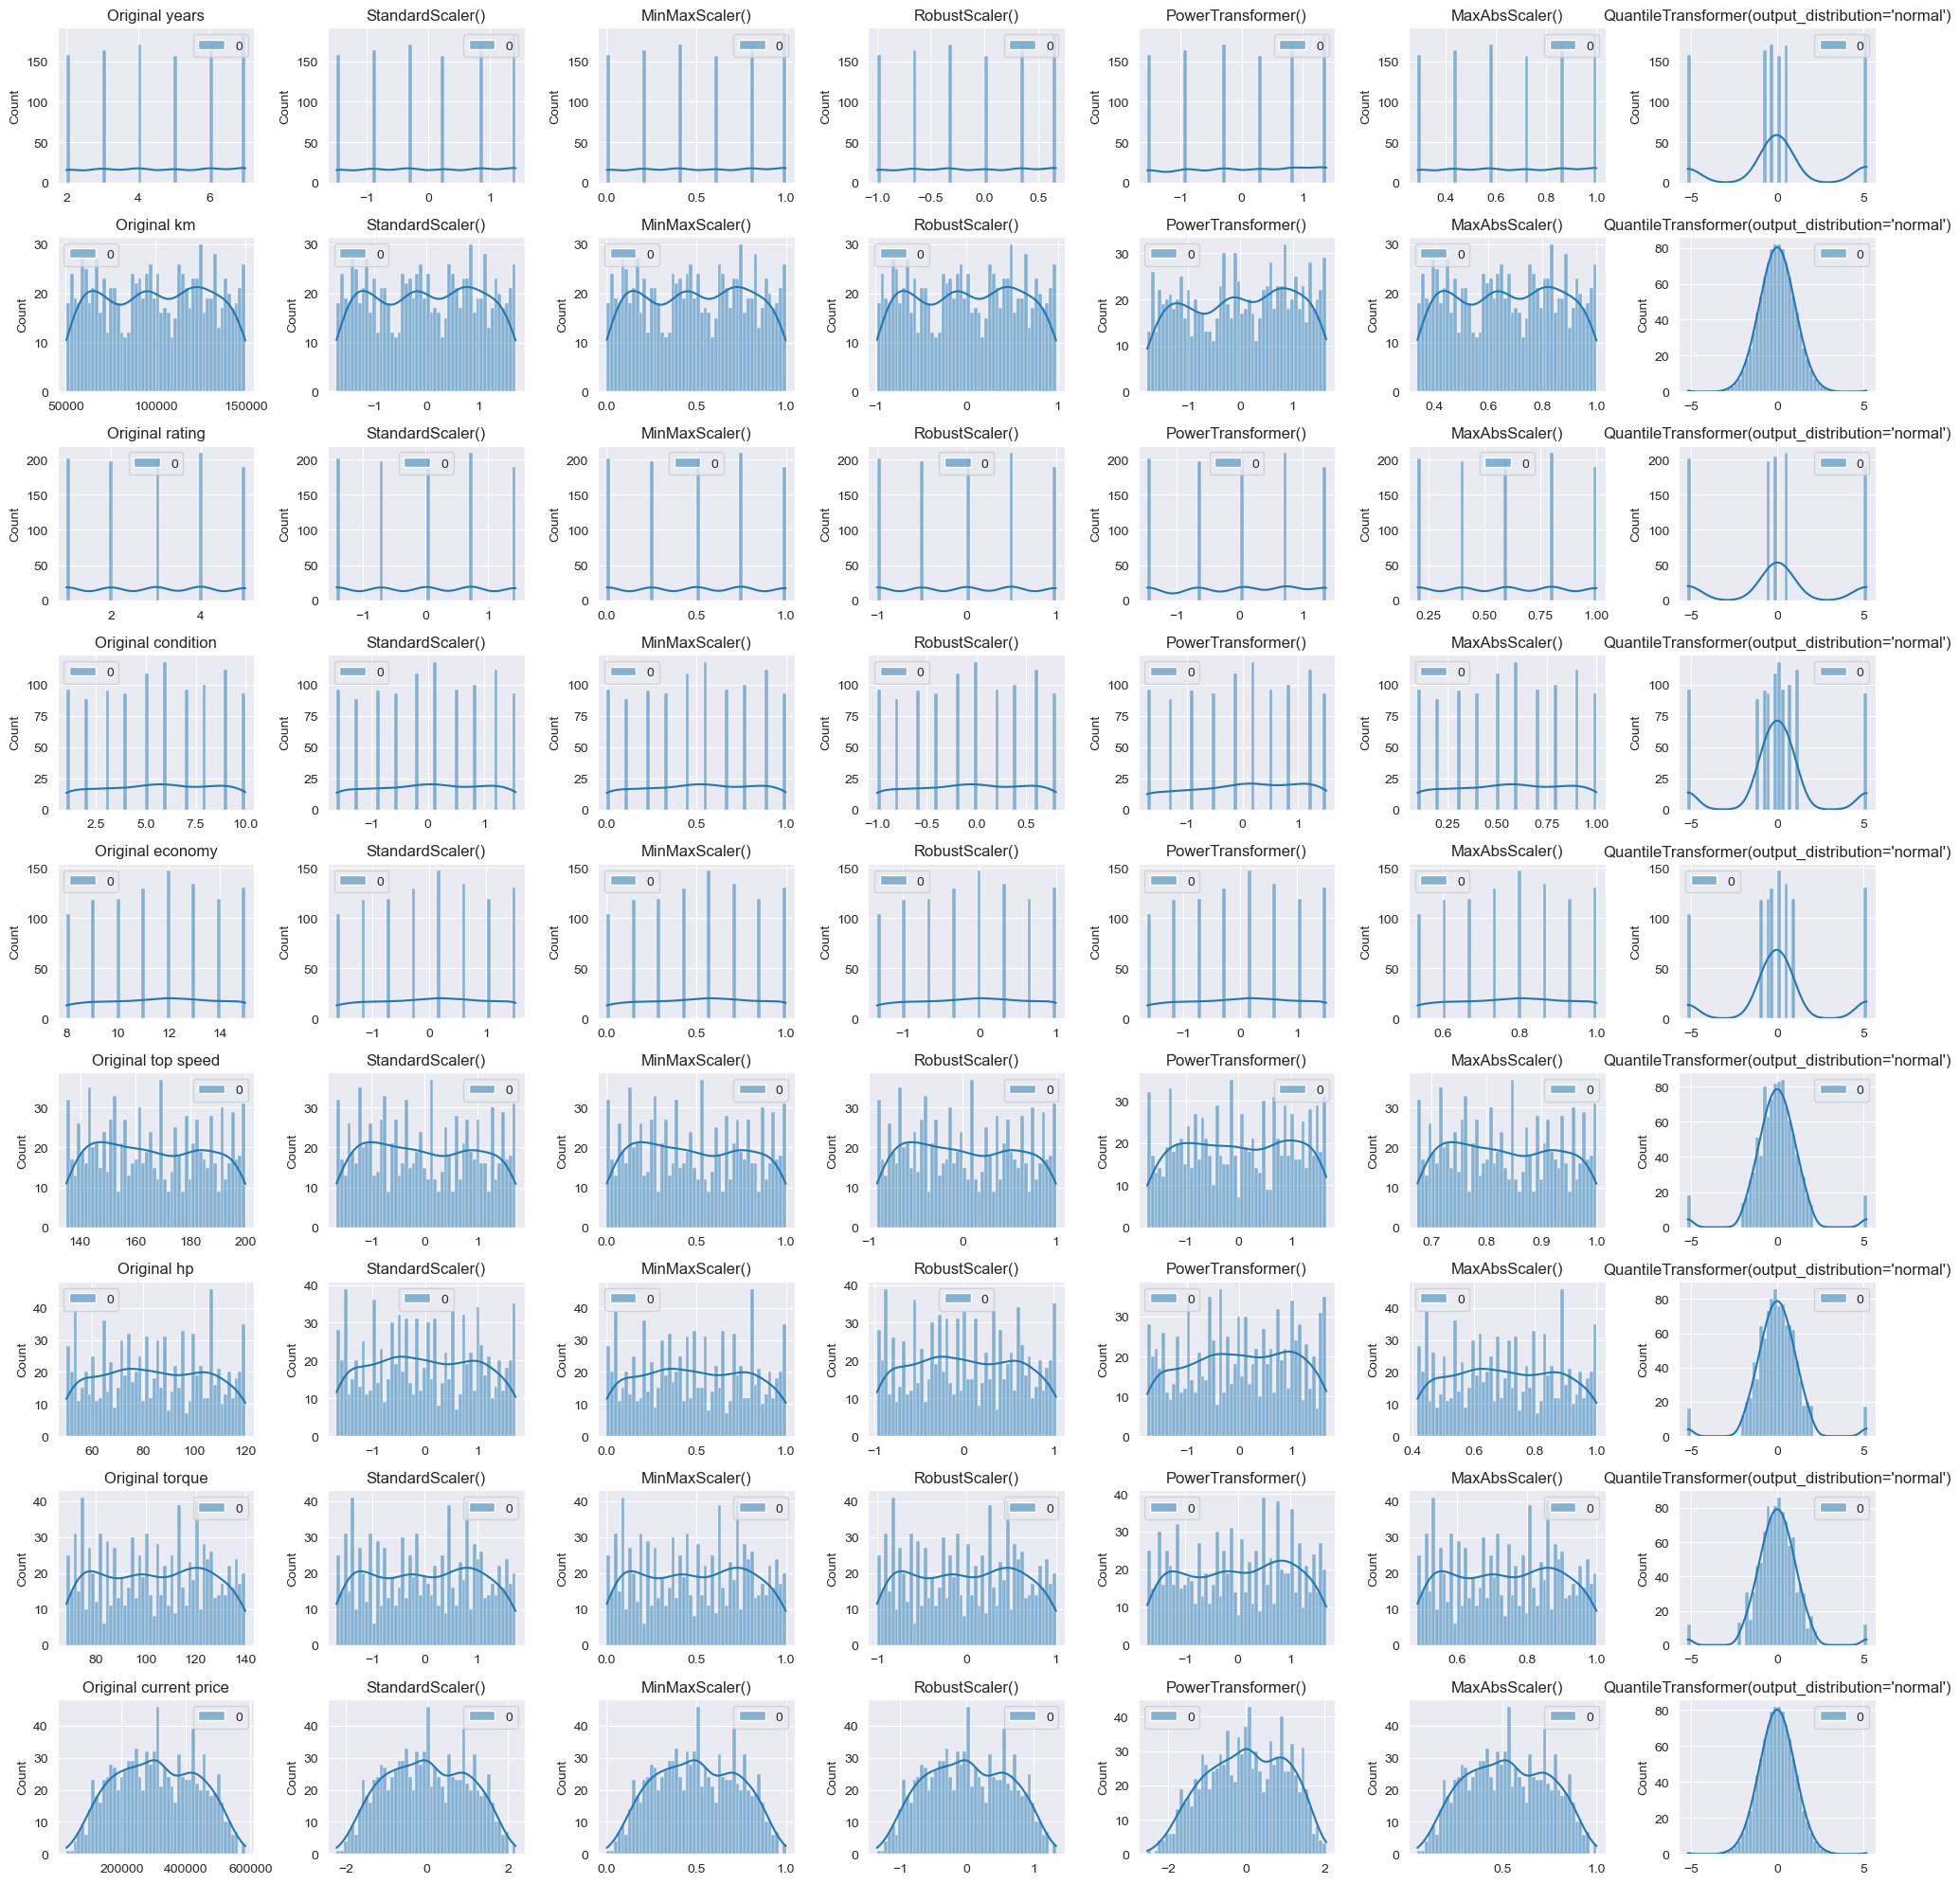

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, MaxAbsScaler, QuantileTransformer

def dist_plot_transformed(df, columns):
    transformations = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), MaxAbsScaler(), QuantileTransformer(output_distribution='normal')]
    fig, axs = plt.subplots(nrows=len(columns), ncols=len(transformations)+1, figsize=(20, 20))

    for item in columns:
        original_data = df[item].values.reshape(-1, 1)
        sns.histplot(original_data, ax=axs[columns.index(item), 0], kde=True, color='blue', bins=50)
        axs[columns.index(item), 0].set_title(f'Original {item}')

        for i, func in enumerate(transformations):
            transformed_data = func.fit_transform(original_data)
            sns.histplot(transformed_data, ax=axs[columns.index(item), i + 1], kde=True, color='purple', bins=50)
            axs[columns.index(item), i + 1].set_title(f'{func}')

    plt.tight_layout()
    plt.show()

dist_plot_transformed(df, df.columns.values.tolist())

### Model Training and Evaluation

In [165]:
xtrn, xaux, ytrn, yaux = train_test_split(df.drop('current price', axis=1), df['current price'], test_size=0.2, random_state=10)
xval, xtest, yval, ytest = train_test_split(xaux, yaux, test_size=0.5, random_state=12)

In [166]:
scaler = StandardScaler()
xtrn = scaler.fit_transform(xtrn)
xval = scaler.transform(xval)
xtest = scaler.transform(xtest)

Simple NN

In [167]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(xtrn, dtype=tf.float32), tf.constant(ytrn, dtype=tf.float32)))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(xval, dtype=tf.float32), tf.constant(yval, dtype=tf.float32)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(xtest, dtype=tf.float32), tf.constant(ytest, dtype=tf.float32)))

train_dataset = train_dataset.shuffle(buffer_size=50, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=50, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=50, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [168]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(tf.constant(xtrn, dtype=tf.float32))

In [169]:
def build_model(use_normalizer=True):

    if use_normalizer:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(xtrn.shape[1],)),
            normalizer,
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1)
        ])  
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(xtrn.shape[1],)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1)
        ])

    model.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
    return model

In [170]:
model = build_model(use_normalizer=False)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=0, mode='auto')
] 
history = model.fit(train_dataset, validation_data=val_dataset, epochs=150, callbacks=callbacks)

Epoch 1/150
25/25 [==============================] - 1s 20ms/step - loss: 303890.8438 - root_mean_squared_error: 329108.0625 - val_loss: 303985.1875 - val_root_mean_squared_error: 332004.7812 - lr: 0.0100
Epoch 2/150
25/25 [==============================] - 0s 12ms/step - loss: 242371.0000 - root_mean_squared_error: 275818.6562 - val_loss: 131673.2031 - val_root_mean_squared_error: 161302.5156 - lr: 0.0100
Epoch 3/150
25/25 [==============================] - 0s 11ms/step - loss: 75092.6875 - root_mean_squared_error: 96225.2969 - val_loss: 51176.8398 - val_root_mean_squared_error: 63160.3086 - lr: 0.0100
Epoch 4/150
25/25 [==============================] - 0s 14ms/step - loss: 44409.0859 - root_mean_squared_error: 54831.5156 - val_loss: 45274.8164 - val_root_mean_squared_error: 55124.3398 - lr: 0.0100
Epoch 5/150
25/25 [==============================] - 0s 11ms/step - loss: 41977.3047 - root_mean_squared_error: 51800.5000 - val_loss: 43868.4961 - val_root_mean_squared_error: 53503.1211 

In [186]:
nn_mae = history.history['loss'][-1]
nn_rmse = history.history['root_mean_squared_error'][-1]
print("Mean Absolute Error: ", nn_mae)
print("Validation Mean Absolute Error: ", history.history['val_loss'][-1])
print("Root Mean Squared Error: ", nn_rmse)
print("Validation Root Mean Squared Error: ", history.history['val_root_mean_squared_error'][-1])

Mean Absolute Error:  35790.1796875
Validation Mean Absolute Error:  40626.69921875
Root Mean Squared Error:  44220.15234375
Validation Root Mean Squared Error:  49994.8046875


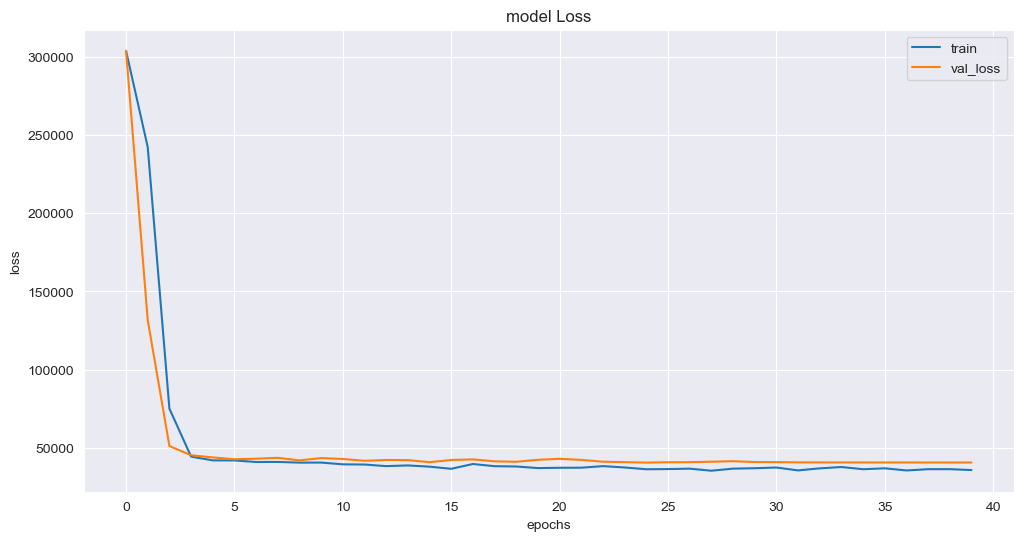

In [172]:
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model Loss")
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','val_loss'])
plt.show()

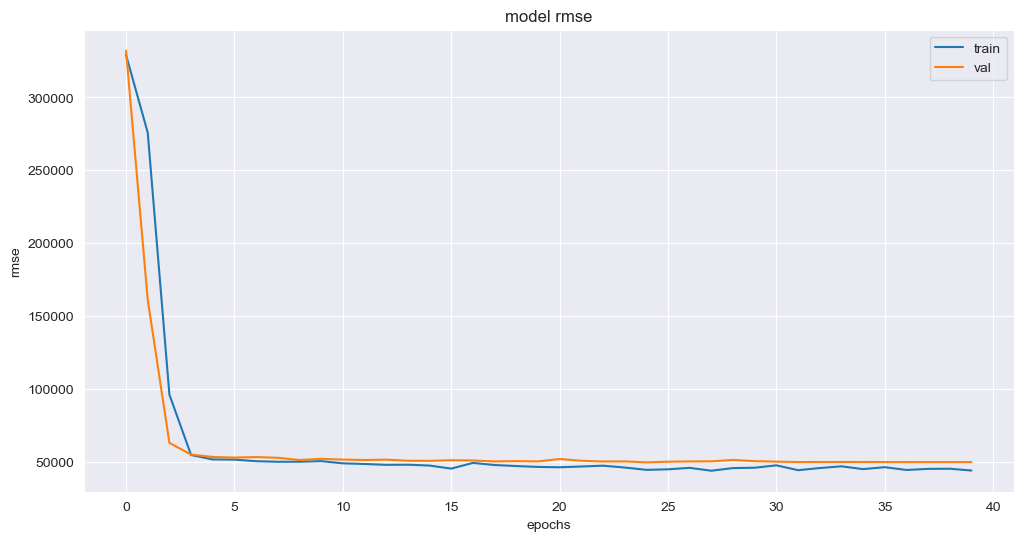

In [173]:
fig = plt.figure(figsize=(12,6))

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("model rmse")
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.legend(['train','val'])
plt.show()

In [174]:
ypred = model.predict(test_dataset)

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 9ms/step


<BarContainer object of 100 artists>

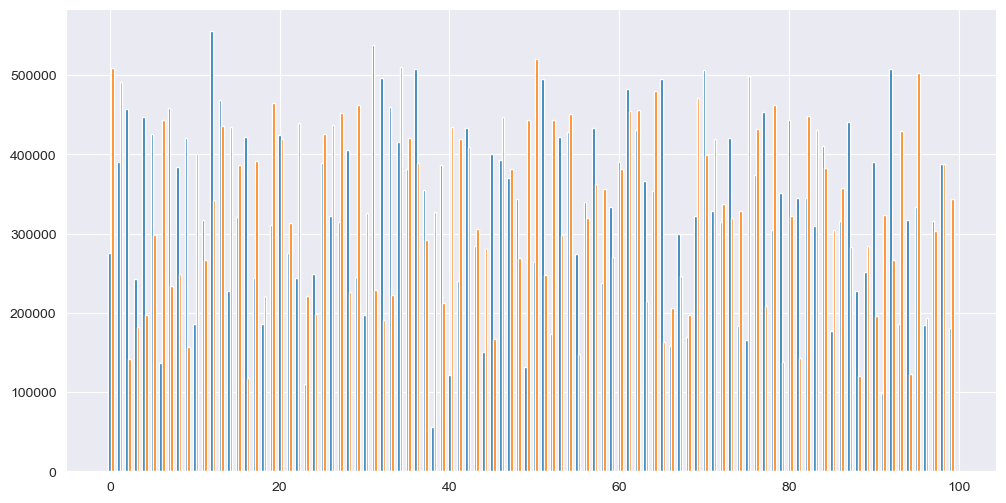

In [175]:

fig = plt.figure(figsize=(12,6))
xaxis = np.arange(100)
plt.bar(xaxis, ytest.values, width=0.3)
plt.bar(xaxis+0.3, ypred.reshape(-1), width=0.3)
# plt.title("model prediction")



XGBoost

In [180]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [25, 45, 50, 55, 60, 100, 200, 300]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2).fit(xtrn, ytrn)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.8833078305512991


In [188]:
from math import sqrt

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=grid_search.best_params_['learning_rate'], 
                             max_depth=grid_search.best_params_['max_depth'], n_estimators=grid_search.best_params_['n_estimators'],
                             eval_metric='rmse')
xgb_model.fit(xtrn, ytrn)
predic = xgb_model.predict(xtest)

xgb_mae = mean_absolute_error(ytest, predic)
xgb_rmse = sqrt(mean_squared_error(ytest, predic))

print(mean_absolute_error(ytest, predic))
print(sqrt(mean_squared_error(ytest, predic)))

36344.218828125
44565.48285601668


Scikit Linear Regression

In [190]:
model = LinearRegression()
model.fit(xtrn, ytrn)
predict = model.predict(xtest)

lr_mae = mean_absolute_error(ytest, predict)
lr_rmse = sqrt(mean_squared_error(ytest, predict))

print("Mean Absolute Error: ", lr_mae)
print("Mean Squared Error: ", lr_rmse)

Mean Absolute Error:  37686.4526804371
Mean Squared Error:  45858.95916919066


In [191]:
score_df = pd.DataFrame({'Model': ['Neural Network', 'XGBoost', 'Linear Regression'], 'mae_score': [nn_mae, xgb_mae, lr_mae], 'rmse_score': [nn_rmse, xgb_rmse, lr_rmse]})

Text(0.5, 1.0, 'RMSE Score')

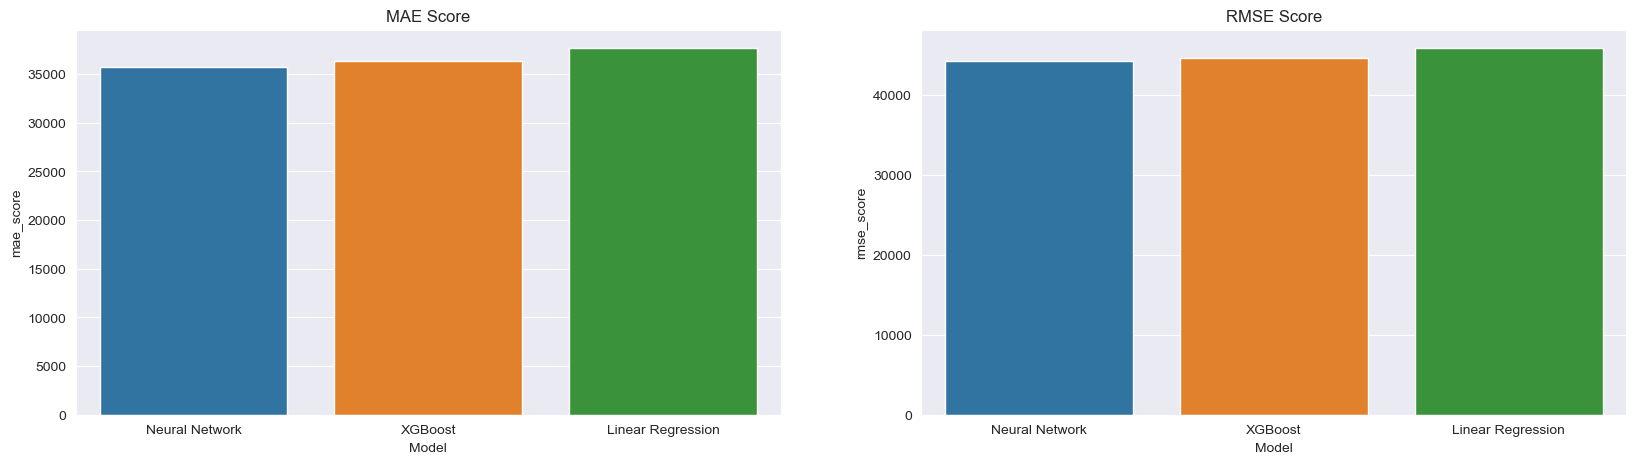

In [202]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.barplot(x='Model', y='mae_score', data=score_df, ax=axs[0])
axs[0].set_title('MAE Score')

sns.barplot(x='Model', y='rmse_score', data=score_df, ax=axs[1])
axs[1].set_title('RMSE Score')